# Problem 1: Split the data

Apply the train-test split to the dataset:


In [110]:
import pandas as pd
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

data = pd.read_csv('data/life_expectancy.csv')

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

# Problem 2: Single variable linear regression model

Encoding the non-numeric variables:

In [111]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data_train['Country'] = label_encoder.fit_transform(data_train['Country'])

Identify the variables with the strongest relationship with the target variable `Life Expectancy at Birth, both sexes (years)` using the Pearson correlation coefficient:

In [112]:
target_variable = 'Life Expectancy at Birth, both sexes (years)'

correlation = data_train.corr(method='pearson')
correlation[target_variable].sort_values(ascending=False)

Life Expectancy at Birth, both sexes (years)                                       1.000000
Human Development Index (value)                                                    0.918341
Expected Years of Schooling, female (years)                                        0.814086
Expected Years of Schooling (years)                                                0.799646
Median Age, as of 1 July (years)                                                   0.797353
Expected Years of Schooling, male (years)                                          0.778834
Mean Years of Schooling, female (years)                                            0.749029
Mean Years of Schooling (years)                                                    0.743001
Mean Years of Schooling, male (years)                                              0.728092
Population with at least some secondary education, female (% ages 25 and older)    0.691909
Population with at least some secondary education, male (% ages 25 and older)   

Construct a linear regression model using the variable with the strongest relationship with the target variable:

In [113]:
from sklearn.linear_model import LinearRegression

candidate_variables = 'Human Development Index (value)'

x_train = data_train[[candidate_variables]]
y_train = data_train[target_variable]

model = LinearRegression()
model.fit(x_train, y_train)


LinearRegression()

Plot the linear regression model:

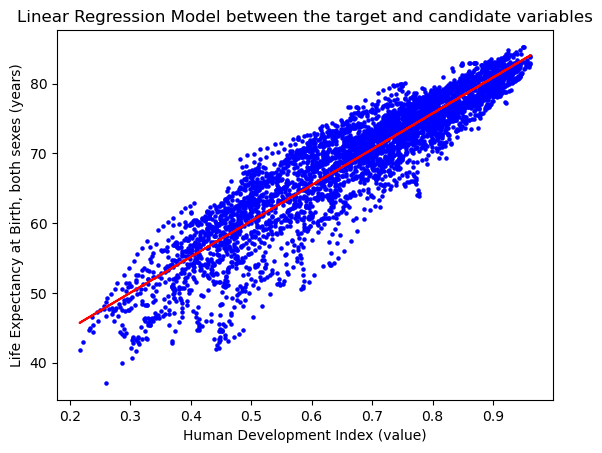

In [114]:
import matplotlib.pyplot as plt

plt.scatter(x_train, y_train, color='blue', s=5)
plt.plot(x_train, model.predict(x_train), color='red')
plt.title('Linear Regression Model between the target and candidate variables')
plt.xlabel(candidate_variables)
plt.ylabel(target_variable)
plt.show()

The following are the coefficient of determination, and the coefficients of the model:

In [115]:
r_squared = model.score(x_train, y_train)
slope = model.coef_[0]
y_intercept = model.intercept_

r_squared, slope, y_intercept

(0.8433493090941087, 51.42339337580666, 34.60462419807177)

Predict the target variable using the test data and computing the mean squared error:

In [116]:
X_test = data_test[[candidate_variables]]
y_pred = model.predict(X_test)

y_real = data_test[target_variable]
mean_squared_error = ((y_pred - y_real) ** 2).mean()
mean_squared_error

12.51925136218853

# Problem 3: Non-linear relationship

Identify the variables with the strongest relationship with the target variable `Life Expectancy at Birth, both sexes (years)` using the Spearman correlation coefficient:

In [117]:
correlation = data_train.corr(method='spearman')
correlation[target_variable].sort_values(ascending=False)

Life Expectancy at Birth, both sexes (years)                                       1.000000
Human Development Index (value)                                                    0.928784
Gross National Income Per Capita (2017 PPP$)                                       0.864828
Median Age, as of 1 July (years)                                                   0.863765
Expected Years of Schooling, female (years)                                        0.834567
Expected Years of Schooling (years)                                                0.819759
Expected Years of Schooling, male (years)                                          0.806563
Material footprint per capita (tonnes)                                             0.789033
Carbon dioxide emissions per capita (production) (tonnes)                          0.762387
Mean Years of Schooling, female (years)                                            0.745441
Mean Years of Schooling (years)                                                 

Plotting the relationship:

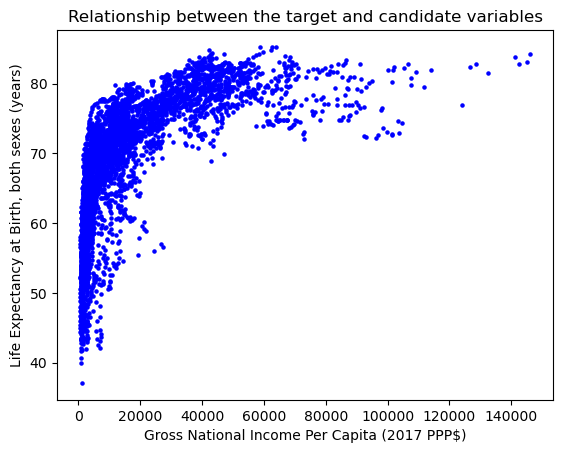

In [118]:
second_candidate_variables = 'Gross National Income Per Capita (2017 PPP$)'

plt.scatter(data_train[second_candidate_variables], data_train[target_variable], color='blue', s=5)
plt.title('Relationship between the target and candidate variables')
plt.xlabel(second_candidate_variables)
plt.ylabel(target_variable)
plt.show()

The relationship appears to be a logarithmic relationship. 

Applying the logarithmic transformation to the candidate variable:

In [119]:
import numpy as np

x_train = data_train[[second_candidate_variables]]
y_train = data_train[target_variable]

log_x_train = np.log(x_train)

model = LinearRegression()
model.fit(log_x_train, y_train)

LinearRegression()

Plotting the linear regression model:

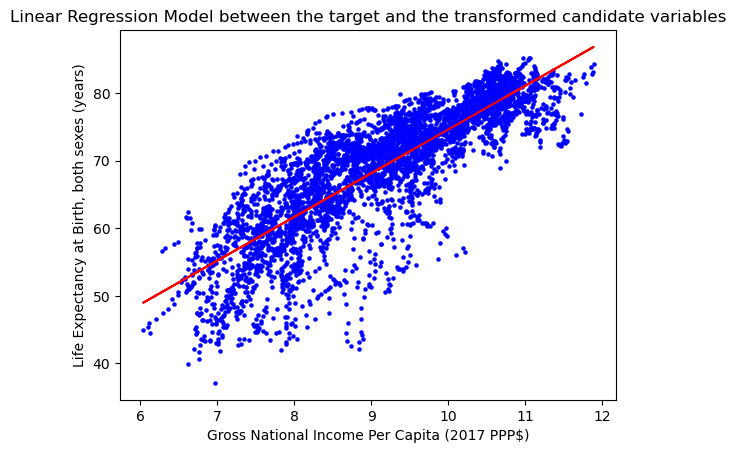

In [120]:
plt.scatter(log_x_train, y_train, color='blue', s=5)
plt.plot(log_x_train, model.predict(log_x_train), color='red')
plt.title('Linear Regression Model between the target and the transformed candidate variables')
plt.xlabel(second_candidate_variables)
plt.ylabel(target_variable)
plt.show()

The following are the Pearson coefficient after the transformation, the coefficient of determination, and the coefficients of the model:

In [121]:
print(f'linreg of log("{second_candidate_variables}") and "{target_variable}"')

pearson_coefficient = np.corrcoef(log_x_train[second_candidate_variables], y_train)[0, 1]
print(f'Pearson coefficient: {pearson_coefficient}')

r_squared = model.score(log_x_train, y_train)
slope = model.coef_[0]
y_intercept = model.intercept_

print(f'R-squared: {r_squared}')
print(f'Slope: {slope}')
print(f'Y-intercept: {y_intercept}')

linreg of log("Gross National Income Per Capita (2017 PPP$)") and "Life Expectancy at Birth, both sexes (years)"
Pearson coefficient: 0.8330226719099858
R-squared: 0.6939267719160522
Slope: 6.467209341589459
Y-intercept: 9.942320920335199


# Problem 4: Multiple linear regression model

Applying a systematic search to identify the variables with the strongest relationship with the target variable `Life Expectancy at Birth, both sexes (years)` without using the most correlated variable:

From the analysis above, we have calculated the spearman coeffient of the different variables and ranked them. We consider the top 10 variables with the highest spearman coeffients. These are 'Human Development Index (value)', 'Median Age, as of 1 July (years)', 'Expected Years of Schooling, female (years)', 'Expected Years of Schooling (years)', 'Expected Years of Schooling, male (years)', 'Material footprint per capita (tonnes)', 'Carbon dioxide emissions per capita (production) (tonnes)', 'Mean Years of Schooling, female (years)', 'Mean Years of Schooling (years)', 'Mean Years of Schooling, male (years)'.

However, upon further analysis 'Expected Years of Schooling (years)' is able to capture the information from 'Expected Years of Schooling. female (years)' and 'Expected Years of Schooling, male (years)'. Moreover, 'Mean Years of Schooling (years)' is able to capture the information from 'Mean Years of Schooling, female (years)', and 'Mean Years of Schooling, male (years)'. Thus, we will only disregarding the variables 'Expected Years of Schooling. female (years)', 'Expected Years of Schooling, male (years)', 'Mean Years of Schooling, female (years)', and 'Mean Years of Schooling, male (years)'. This leave us with 6 remaining variables to consider further.

In [122]:
top_10_variable_data = data_train[['Human Development Index (value)', 'Median Age, as of 1 July (years)', 'Expected Years of Schooling (years)', 'Material footprint per capita (tonnes)', 'Carbon dioxide emissions per capita (production) (tonnes)', 'Mean Years of Schooling (years)', target_variable]]
print(top_10_variable_data.shape)

#drop rows with missing data. Most rows are present after dropping these rows so this step is still reasonable. 
cleaned_top_10_data = top_10_variable_data.dropna()
print(cleaned_top_10_data.shape)
print(cleaned_top_10_data.columns)

# x_train_top_5 = cleaned_top_5_data.drop(columns=[target_variable])
# y_train_top_5 = cleaned_top_5_data[target_variable]
# print(x_train_top_5.shape)
# print(y_train_top_5.shape)

(4442, 7)
(3727, 7)
Index(['Human Development Index (value)', 'Median Age, as of 1 July (years)',
       'Expected Years of Schooling (years)',
       'Material footprint per capita (tonnes)',
       'Carbon dioxide emissions per capita (production) (tonnes)',
       'Mean Years of Schooling (years)',
       'Life Expectancy at Birth, both sexes (years)'],
      dtype='object')


In [123]:
top_10_candidate_variables = ['Human Development Index (value)', 'Median Age, as of 1 July (years)', 'Expected Years of Schooling (years)', 'Material footprint per capita (tonnes)', 'Carbon dioxide emissions per capita (production) (tonnes)', 'Mean Years of Schooling (years)']

x_train_top_10 = cleaned_top_10_data[top_10_candidate_variables]
y_train_top_10 = cleaned_top_10_data[target_variable]

model_top_10 = LinearRegression()
model_top_10.fit(x_train_top_10, y_train_top_10)

LinearRegression()

In [124]:
top_10_variable_data_test = data_test[['Human Development Index (value)', 'Median Age, as of 1 July (years)', 'Expected Years of Schooling (years)', 'Material footprint per capita (tonnes)', 'Carbon dioxide emissions per capita (production) (tonnes)', 'Mean Years of Schooling (years)', target_variable]]
print(top_10_variable_data.shape)

#drop rows with missing data. Most rows are present after dropping these rows so this step is still reasonable. 
cleaned_top_10_data_test = top_10_variable_data_test.dropna()

X_test = cleaned_top_10_data_test[top_10_candidate_variables]
y_pred = model_top_10.predict(X_test)

y_real = cleaned_top_10_data_test[target_variable]
mean_squared_error = ((y_pred - y_real) ** 2).mean()
print(mean_squared_error)
r_squared = model_top_10.score(x_train_top_10, y_train_top_10)
slope = model_top_10.coef_[0]
y_intercept = model_top_10.intercept_


# check everything but add pearson correlation coefficeint 

(4442, 7)
6.998149588994278
